# Product recommendation based on visual similarity


The goal of this experiment is to make a very basic recommender system: for a given fashion product, we want to recommend products that look similar. 

This kind of recommender system is often used when browsing shopping websites. They usually appear on product pages as a "you may also like" section.

The idea behind this recommender system is simple: if a customer is showing interest towards a product by browsing its page, he may also be interested by products that are similar.


## How to proceed ?

We will used a pre-trained CNN model from Keras to extract the image features.

Then we will compute similarities between the different products using the previously extracted image features.

Other type of information can be used for this purpose such as the product category, size, color, etc. if the data is available, but that is not the case here.

## 0. imports and parameters setup

In [58]:
import pandas as pd

In [59]:
dfmeta = pd.read_csv('E:/Airtel Xstream/fyp datasets/prod_ratings.csv')

In [60]:
dfmeta.head()

,userID,prod_ID,rating,imgurl,prod_name
0,A5JLAU2ARJ0BO,1400532655,1.0,http://ecx.images-amazon.com/images/I/51lBXZsM...,Barnes &amp; Noble Nook Color eReader
1,A1T1YSCDW0PD25,B00000DM9W,5.0,http://ecx.images-amazon.com/images/I/41N1GD82...,Sony ICF-S79V Weather Band Shower Radio (Disco...
2,A3CW0ZLUO5X2B1,B00000K135,5.0,http://ecx.images-amazon.com/images/I/71QD0N8R...,Brother M231 1/2-Inch Black on White Tape for ...
3,A22CW0ZHY3NJH8,B00000K135,5.0,http://ecx.images-amazon.com/images/I/71QD0N8R...,Brother M231 1/2-Inch Black on White Tape for ...
4,A231WM2Z2JL0U3,B00000K4KH,5.0,http://ecx.images-amazon.com/images/I/41SO%2B1...,Kensington 64068F MicroSaver Notebook Lock and...


In [61]:
dfmeta.shape

(3567, 5)

In [62]:
import urllib.request

In [69]:
for i in range(500):
        urllib.request.urlretrieve(dfmeta['imgurl'][i], "E:/Airtel Xstream/fyp datasets/images/electronics/"+dfmeta['prod_ID'][i]+".png")

In [18]:
!pip install keras

In [5]:
!pip install tensorflow

  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.6-py3-none-any.whl (47 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=2f7f57b86ce062bb1740415e18c8854435add0671f55609285f4031b6f211a95
  Stored in directory: c:\users\ehtesham\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=bf44190117a8996189235d9f22aaab807cf7764de2d0f3cfd4747a8b0217abcc
  Stored in directory: c:\users\ehtesham\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built wrapt termcolor
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2


In [5]:
# imports
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [70]:
# parameters setup
imgs_path = "E:/Airtel Xstream/fyp datasets/images/electronics/"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

## 1. load the VGG pre-trained model from Keras

Keras module contains several pre-trained models that can be loaded very easily. 

For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that will be able to interpret the image contents.

In this example we will load the VGG16 model trained on imagenet, a big labeled images database.

If we take the whole model, we will get an output containing probabilities to belong to certain classes, but that is not what we want.

We want to retrieve all the information that the model was able to get in the images.

In order to do so, we have to remove the last layers of the CNN which are only used for classes predictions.

In [71]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 2. get the images paths

In [72]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]
print("number of images:",len(files))

number of images: 299


## 3. feed one image into the CNN

First we observe what output we get when putting one image into the CNN.

The following steps are:
- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

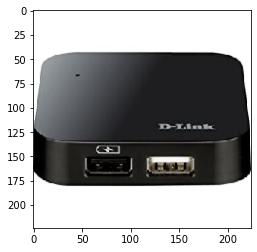

image loaded successfully!


In [74]:
# load an image in PIL format
original = load_img(files[50], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [75]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


## 4. feed all the images into the CNN

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [77]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


In [78]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(299, 4096)

In [79]:
file_names = []
for i in range(len(files)):
    last = files[i].split('/')[-1]
    name = last.split('.')[0]
    file_names.append(name)

In [80]:
file_names

['1400532655',
 'B00000DM9W',
 'B00000K135',
 'B00000K4KH',
 'B00001P4XA',
 'B00001P4ZH',
 'B00001W0DI',
 'B00001WRSJ',
 'B00003CWDH',
 'B00004SABB',
 'B00004SB92',
 'B00004TDLD',
 'B00004THCZ',
 'B00004TWM6',
 'B00004W3ZQ',
 'B00004WCGF',
 'B00004WCIC',
 'B00004XOM3',
 'B00004Z5D1',
 'B00004Z5M1',
 'B00004Z5PY',
 'B00004ZCJE',
 'B0000510ZO',
 'B000051299',
 'B000053HH5',
 'B000056SSM',
 'B00005A1K1',
 'B00005ARK3',
 'B00005ATMB',
 'B00005AW1H',
 'B00005BC0K',
 'B00005K47X',
 'B00005LEN4',
 'B00005ML7Q',
 'B00005T39Y',
 'B00005T3C8',
 'B00005T3G0',
 'B00005T6GZ',
 'B00005Y3OM',
 'B000062VUO',
 'B000063574',
 'B0000642RX',
 'B000065BP9',
 'B000066R6M',
 'B000067RT6',
 'B000067RVL',
 'B000067S60',
 'B000067SOH',
 'B000068O16',
 'B000068O3C',
 'B00006B7DA',
 'B00006BBAC',
 'B00006FXR9',
 'B00006HSML',
 'B00006HYKM',
 'B00006HYP6',
 'B00006HYPV',
 'B00006HZ0L',
 'B00006I53S',
 'B00006I53X',
 'B00006I5WJ',
 'B00006IS4X',
 'B00006IW1X',
 'B00006JN3G',
 'B00006RVPW',
 'B000075UZ7',
 'B00007E7

# 5. compute cosine similarities

Now that we have features for every image, we can compute similarity metrics between every image couple.

We will use here the cosine similarity metric.

In [81]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=file_names, index=file_names)
cos_similarities_df.head()

,1400532655,B00000DM9W,B00000K135,B00000K4KH,B00001P4XA,B00001P4ZH,B00001W0DI,B00001WRSJ,B00003CWDH,B00004SABB,...,B000F5FKHI,B000F7JCRA,B000F7QRTG,B000F9YN22,B000FBK3QK,B000FCSXBQ,B000FDTNZK,B000FFISV8,B000FHD7PI,B000FITKK8
1400532655,1.000000,0.176788,0.286043,0.268389,0.142651,0.237388,0.188319,0.255745,0.333126,0.218945,...,0.137814,0.278113,0.264758,0.220504,0.321351,0.209254,0.220533,0.293433,0.180910,0.443716
B00000DM9W,0.176788,1.000000,0.367093,0.296822,0.315902,0.294691,0.312301,0.265121,0.272461,0.316490,...,0.334912,0.362908,0.236334,0.345789,0.393523,0.326389,0.287439,0.449726,0.216835,0.295006
B00000K135,0.286043,0.367093,1.000000,0.456062,0.286848,0.480812,0.432195,0.305754,0.600506,0.428290,...,0.372582,0.338818,0.267327,0.511917,0.341366,0.327729,0.415987,0.288695,0.362307,0.425184
B00000K4KH,0.268389,0.296822,0.456062,1.000000,0.281027,0.451953,0.310572,0.415578,0.482295,0.288282,...,0.274081,0.416341,0.176553,0.436916,0.314210,0.298283,0.313980,0.269308,0.339811,0.426539
B00001P4XA,0.142651,0.315902,0.286848,0.281027,1.000000,0.294028,0.325623,0.322649,0.254348,0.277359,...,0.392407,0.385108,0.191252,0.342183,0.319124,0.265958,0.286657,0.310318,0.234450,0.244260


In [82]:
cos_similarities_df.index

Index(['1400532655', 'B00000DM9W', 'B00000K135', 'B00000K4KH', 'B00001P4XA',
       'B00001P4ZH', 'B00001W0DI', 'B00001WRSJ', 'B00003CWDH', 'B00004SABB',
       ...
       'B000F5FKHI', 'B000F7JCRA', 'B000F7QRTG', 'B000F9YN22', 'B000FBK3QK',
       'B000FCSXBQ', 'B000FDTNZK', 'B000FFISV8', 'B000FHD7PI', 'B000FITKK8'],
      dtype='object', length=299)

In [83]:
cos_similarities_df.to_csv('img_similarity.csv')

In [84]:
ddf = pd.read_csv('img_similarity.csv',index_col=0)
#ddf.rename(columns = {'Unnamed: 0':'prod_ID'}, inplace = True) 
ddf.head()

,1400532655,B00000DM9W,B00000K135,B00000K4KH,B00001P4XA,B00001P4ZH,B00001W0DI,B00001WRSJ,B00003CWDH,B00004SABB,...,B000F5FKHI,B000F7JCRA,B000F7QRTG,B000F9YN22,B000FBK3QK,B000FCSXBQ,B000FDTNZK,B000FFISV8,B000FHD7PI,B000FITKK8
1400532655,1.000000,0.176788,0.286043,0.268389,0.142651,0.237388,0.188319,0.255745,0.333126,0.218945,...,0.137814,0.278113,0.264757,0.220504,0.321351,0.209254,0.220533,0.293433,0.180910,0.443716
B00000DM9W,0.176788,1.000000,0.367093,0.296822,0.315902,0.294691,0.312301,0.265121,0.272461,0.316490,...,0.334912,0.362908,0.236334,0.345789,0.393523,0.326389,0.287439,0.449726,0.216835,0.295006
B00000K135,0.286043,0.367093,1.000000,0.456062,0.286848,0.480812,0.432195,0.305754,0.600506,0.428290,...,0.372582,0.338818,0.267327,0.511916,0.341366,0.327729,0.415987,0.288695,0.362307,0.425184
B00000K4KH,0.268389,0.296822,0.456062,1.000000,0.281027,0.451953,0.310572,0.415578,0.482295,0.288282,...,0.274081,0.416341,0.176553,0.436916,0.314210,0.298283,0.313980,0.269308,0.339811,0.426539
B00001P4XA,0.142651,0.315902,0.286848,0.281027,1.000000,0.294028,0.325623,0.322649,0.254348,0.277359,...,0.392407,0.385108,0.191252,0.342183,0.319124,0.265958,0.286657,0.310318,0.234450,0.244260


# 6. retrieve most similar products

The final step is to implement a function that, for any given product, returns the visually most similar products.

In [85]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")
    print(given_img)

#     original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
#     plt.imshow(original)
#     plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    
    


    for i in range(0,len(closest_imgs)):
        print(closest_imgs[i])
#         original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
#         plt.imshow(original)
#         plt.show()
#         lst = get_product_details(closest_imgs[i])
#         print('title: '+lst[0])
#         print('description: '+lst[1])
#         print("similarity score : ",closest_imgs_scores[i])
    return (closest_imgs)

In [86]:
retrieve_most_similar_products(file_names[3])

-----------------------------------------------------------------------
original product:
B00000K4KH
-----------------------------------------------------------------------
most similar products:
B00009X6PH
B000ENUCR4
B00006HYPV
B000CKVOOY
B000204SWE


Index(['B00009X6PH', 'B000ENUCR4', 'B00006HYPV', 'B000CKVOOY', 'B000204SWE'], dtype='object')

In [87]:
retrieve_most_similar_products("B00001W0DI")

-----------------------------------------------------------------------
original product:
B00001W0DI
-----------------------------------------------------------------------
most similar products:
B000AJIF4E
B000095SB4
B00067OF80
B000CQPWMS
B000629GES


Index(['B000AJIF4E', 'B000095SB4', 'B00067OF80', 'B000CQPWMS', 'B000629GES'], dtype='object')

# Conclusion
We saw above that this very basic recommender system is able to find similar products accurately: most of the time the retrieved products have the same purpose and even look very similar.

This could be incorporated directly into a website using a web framework such as Flask.